In [2]:
from jax import numpy as jnp
from jax import vmap, grad, jit
import s2fft
from jax.scipy.special import sph_harm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import jax
jax.config.update("jax_enable_x64", True)

from jax import vmap
import jax.numpy as jnp
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import s2fft

def to_points(theta, phi):
    x = jnp.sin(phi) * jnp.cos(theta)
    y = jnp.sin(phi) * jnp.sin(theta)
    z = jnp.cos(phi)
    return x, y, z


def colormap(x):
    cmap = plt.get_cmap('viridis', 256)
    return cmap(x)

def normalize(v):
    max = jnp.max(v)
    min = jnp.min(v)
    return (v - min) / (max - min)

def sph_plot(f, theta, phi, ax):
    x, y, z = to_points(theta, phi)
    ax.plot_surface(x, y, z, facecolors=f, rstride=1, cstride=1, shade=False)



JAX is not using 64-bit precision. This will dramatically affect numerical precision at even moderate L.


In [3]:
from jax.numpy.fft import fft, ifft
f = jnp.load('data/Gaia_EDR3_flux.npy')
f = f[::9, ::9]
#f = f[::31, ::31]
f = f + 1j * f**2
L = f.shape[0]
m_max = (f.shape[1]-1)//2
#f_mirror = vmap(jnp.roll, (0, None))(f[::-1], m_max)
#f_mirror_mirror = vmap(jnp.roll, (0, None))(f_mirror[::-1], m_max)
#print(jnp.max(jnp.abs(f_mirror_mirror-f)))
#f = (f + f_mirror) + 1j * (f**2 - f_mirror**2)
#print(f.shape)

ls = jnp.arange(L).astype(jnp.int32)
ms = jnp.arange(-m_max, m_max+1).astype(jnp.int32)
Ls, Ms = jnp.meshgrid(ls, ms, indexing='ij')


sampling = "mw"
thetas = s2fft.sampling.s2_samples.thetas(L, sampling)
phis = s2fft.sampling.s2_samples.phis_equiang(L, sampling)
Theta, Phi = jnp.meshgrid(thetas, phis, indexing='ij')

def func(theta, phi, flm, Ls, Ms):
    func_lm = lambda m, l: sph_harm(m, l, jnp.array([theta]), jnp.array([phi]), n_max=jnp.max(Ls))
    return jnp.sum(vmap(func_lm, (0, 0))(Ms, Ls) * flm)
    
flm = s2fft.forward_jax(f, L, sampling=sampling)
flm = flm + (-1)**(Ls+Ms)*jnp.conjugate(flm[:, ::-1]) 
f_recov = s2fft.inverse_jax(flm, L, sampling=sampling)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
flm_rot = s2fft.utils.rotation.rotate_flms(flm, L, rotation=(jnp.pi, 0, 0))
f_rot = s2fft.inverse_jax(flm_rot, L, sampling=sampling)

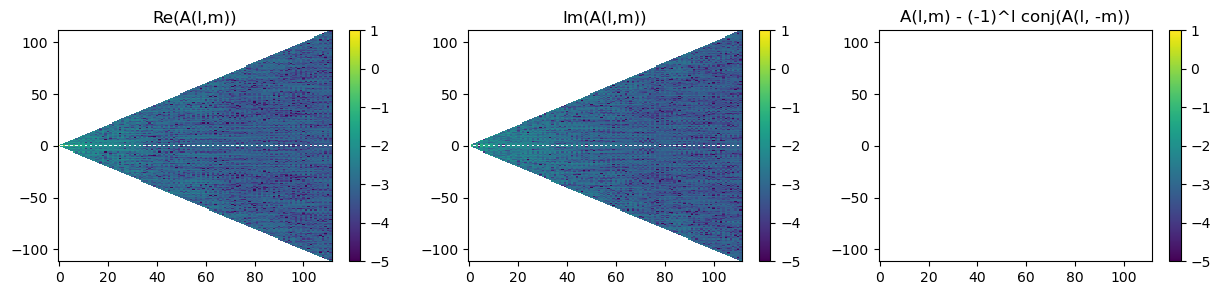

In [5]:
vmin, vmax = -5, 1
plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.title("Re(A(l,m))")
plt.pcolormesh(Ls, Ms, jnp.log10(jnp.abs(flm.real)), vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(132)
plt.title("Im(A(l,m))")
plt.pcolormesh(Ls, Ms, jnp.log10(jnp.abs(flm.imag)), vmin=vmin, vmax=vmax)
plt.colorbar()

plt.subplot(133)
plt.title("A(l,m) - (-1)^l conj(A(l, -m))")
diff = flm - (-1)**(Ls+Ms) * jnp.conjugate(flm[:, ::-1])
plt.pcolormesh(Ls, Ms, jnp.log10(jnp.abs(diff)), vmin=vmin, vmax=vmax)
plt.colorbar()

1.9910313901345293


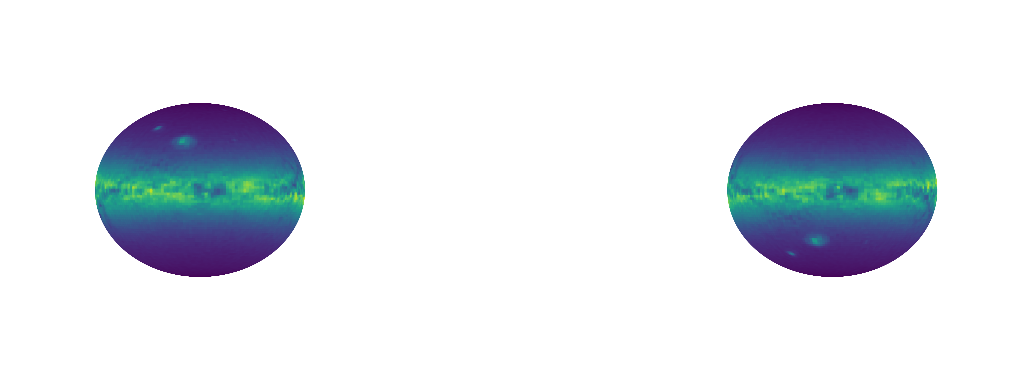

In [6]:
plt.figure(figsize=(15, 4))
print(jnp.max(phis)/jnp.pi)
Thetas, Phis = jnp.meshgrid(thetas, phis, indexing='ij')
fs = [f_recov, f_rot]
for i in range(2):
    ax = plt.subplot(1, 2, i+1, projection='3d')
    v = fs[i]
    v = colormap(normalize(v.real))
    sph_plot(v, Phis, Thetas, ax)
    ax.view_init(elev=0, azim=90)
    plt.axis("off")
plt.tight_layout()

1.9910313901345293
1.0


(-1.0999677493031808,
 1.099868519514484,
 -1.099945422262232,
 1.099945422262232,
 -0.9999007677495128,
 1.0)

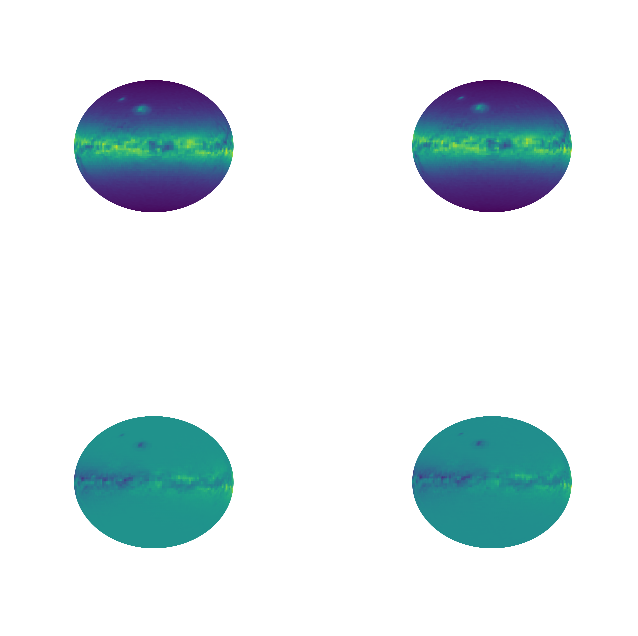

In [7]:
plt.figure(figsize=(8, 8))

print(jnp.max(phis)/jnp.pi)
print(jnp.max(thetas)/jnp.pi)

Thetas, Phis = jnp.meshgrid(thetas, phis, indexing='ij')

f_inspect = f_recov
ax = plt.subplot(2, 2, 1, projection='3d')
v = f_inspect
v = colormap(normalize(v.real))
sph_plot(v, Phis, Thetas, ax)
ax.view_init(elev=0, azim=90)
plt.axis("off")

ax = plt.subplot(2, 2, 2, projection='3d')
v = f_inspect
v = colormap(normalize(v.real))
sph_plot(v, Phis+jnp.pi, jnp.pi-Thetas, ax)
ax.view_init(elev=0, azim=90)
plt.axis("off")

ax = plt.subplot(2, 2, 3, projection='3d')
v = f_inspect
v = colormap(normalize(v.imag))
sph_plot(v, Phis, Thetas, ax)
ax.view_init(elev=0, azim=90)
plt.axis("off")

ax = plt.subplot(2, 2, 4, projection='3d')
v = f_inspect
v = colormap(normalize(-v.imag))
sph_plot(v, Phis+jnp.pi, jnp.pi-Thetas, ax)
ax.view_init(elev=0, azim=90)
plt.axis("off")


[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]


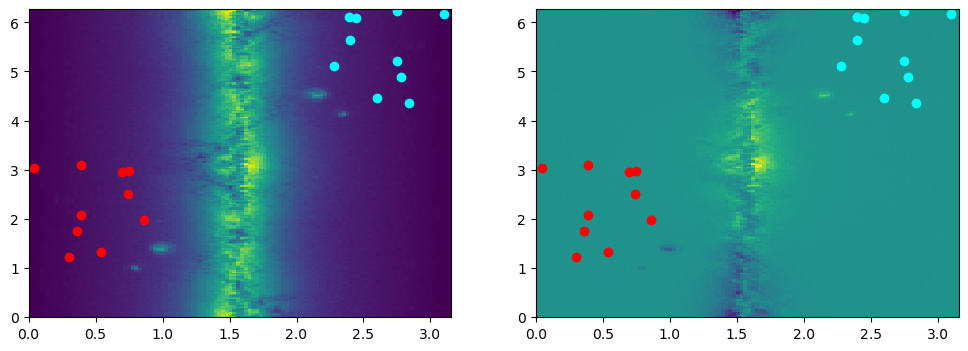

In [8]:
import numpy as np

fields = [f_recov.real, f_recov.imag]
Ntest = 10
theta0, phi0 = np.random.rand(Ntest)*jnp.pi/2, np.random.rand(Ntest)*2*jnp.pi/2
x0, y0, z0 = to_points(phi0, theta0)
x01, y01, z01 = to_points((phi0 + jnp.pi)%(2*jnp.pi),jnp.pi - theta0)

print(x0*x01+y0*y01+z0*z01)
plt.figure(figsize=(12, 4))
for i in range(2):
    plt.subplot(120+i+1)
    plt.pcolormesh(Theta, Phi, fields[i])
    plt.scatter(theta0, phi0, color='red')
    plt.scatter(jnp.pi - theta0, (phi0 + jnp.pi)%(2*jnp.pi), color='cyan')

In [23]:
alpha, beta, gamma = jnp.pi/4, jnp.pi/5, 0
dls = s2fft.utils.rotation.generate_rotate_dls(L, beta)

In [24]:
flm_rot = s2fft.utils.rotation.rotate_flms(flm, L, rotation=(alpha, beta, gamma), dl_array=dls)
f_rot = s2fft.inverse_jax(flm_rot, L, sampling=sampling)

1.9910313901345293


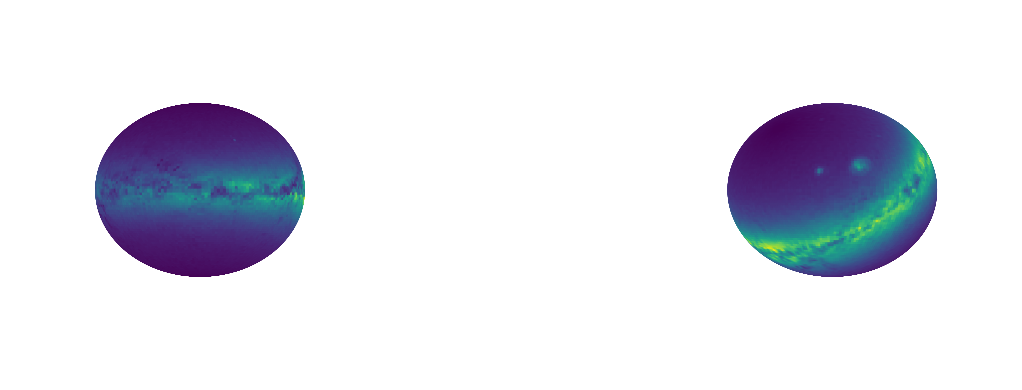

In [19]:
plt.figure(figsize=(15, 4))
print(jnp.max(phis)/jnp.pi)
Thetas, Phis = jnp.meshgrid(thetas, phis, indexing='ij')
fs = [f, f_rot]
for i in range(2):
    ax = plt.subplot(1, 2, i+1, projection='3d')
    v = fs[i]
    v = colormap(normalize(v.real))
    sph_plot(v, Phis, Thetas, ax)
    ax.view_init(elev=0, azim=90)
    plt.axis("off")
plt.tight_layout()